In [1]:
#Colab setting
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/DSAIL')

import os
os.chdir('/content/drive/My Drive/DSAIL')

Mounted at /content/drive


In [2]:
import numpy as np
train_rating_matrix = np.load('Epinions/train_rating_matrix.npy')
test_rating_matrix = np.load('Epinions/test_rating_matrix.npy')
ui_uk_matrix= np.load('Epinions/ui_uk_matrix.npy')

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

class SOREG(nn.Module):
  def __init__(self, train_R = train_rating_matrix, test_R = test_rating_matrix, trust = ui_uk_matrix, l=10, alpha = 0.01,lamb1 = 0.001, lamb2 =0.001, learning_rate=1e-3, epochs= 100):
    '''
    SOREG
    model1
    --average based

    얘는 trust matrix를 factorization 하기보다는 regularization term에 추가함
    '''
    super(SOREG, self).__init__()

    # 논문은 특이하게 m이 user 수, n이 item 수
    self.m, self.n = train_R.shape # Rating
    self.test_n, self.test_m = test_R.shape

    self.latent_dimension = l

    # self.train_R = train_R
    # self.test_R = test_R   # 20 비율       (100, 1000)
    # self.trust = trust     # trust ratings (100, 100)

    self.train_R = torch.from_numpy(train_R).float()
    self.test_R = torch.from_numpy(test_R).float()
    self.trust = torch.from_numpy(trust).float()

    self.lr = learning_rate
    self.epoch = epochs
    self.lamb1 = lamb1
    self.lamb2 = lamb2
    self.alpha = alpha

    self.U = nn.Parameter(torch.randn(self.latent_dimension, self.m)) # (l, m)
    self.V = nn.Parameter(torch.randn(self.latent_dimension, self.n)) # (l, n) = > (m, n) : Ratings

    self.outlink_friends = {user: np.where(trust[user, :] > 0)[0] for user in range(self.m)}
    self.inlink_friends = {user: np.where(trust[:, user] > 0)[0] for user in range(self.m)}

    self.out_friends_num = torch.sum(self.trust, dim=1) # (m,)

    self.optimizer = torch.optim.Adam(self.parameters(), lr= self.lr)

    self.completed_rating_matrix = torch.matmul(self.U.T, self.V)

  def forward_user_item(self, u):
    # user 들어올 때마다 모든 item에 대한 rating 차이 구하기
    predicted_rating = torch.matmul(self.U[:, u].T, self.V) # (l,) (l, n) => (n)
    loss = 0
    for v in range(self.n):
      # R이 있는 경우만
      if self.train_R[u, v]:
        loss += (self.train_R[u, v] - predicted_rating[v]) ** 2

    return loss / 2

  def similarity(self, i, f):
    # PCC
    rating_i = self.train_R[i, :]
    rating_f = self.train_R[f, :]
    common_items = (rating_i != 0) & (rating_f != 0)

    # No common items, similarity is undefined
    if torch.sum(common_items) == 0:
      return torch.tensor(0.0)

    rating_i_common = rating_i[common_items]
    rating_f_common = rating_f[common_items]
    mean_i = torch.mean(rating_i_common)
    mean_f = torch.mean(rating_f_common)

    denominator_i = torch.sqrt(torch.sum((rating_i_common - mean_i)**2))
    denominator_f = torch.sqrt(torch.sum((rating_f_common - mean_f)**2))
    # Divide by zero
    if denominator_i == 0 or denominator_f == 0:
      return torch.tensor(0.0)

    sim = torch.sum((rating_i_common - mean_i) * (rating_f_common - mean_f)) / (denominator_i * denominator_f)

    return sim

  # def forward_user_average(self, u):
  #   # self.U[u]가 들어오면 해당 user의 outlink friends들
  #   outlink_friends = self.outlink_friends[u]
  #   outlink_sum = 0
  #   for friend in outlink_friends:
  #     outlink_sum += self.U[:, friend]
  #   loss = torch.norm((self.U[:, u] - outlink_sum / len(outlink_friends)), p='fro')

  #   return self.alpha * loss / 2

  def forward_user_average(self, u):
    # self.U[u]가 들어오면 해당 user의 outlink friends weighted
    outlink_friends = self.outlink_friends[u]
    sim = 0
    outlink_sum = 0
    num_common = 0
    sum = 0

    if len(outlink_friends) == 0:
      return 0
    for friend in outlink_friends:
      s = self.similarity(u, friend)
      sum += self.U[:, friend]
      outlink_sum += self.U[:, friend] * s
      sim += s
    # sim = 0인 경우 그냥 average로 가는게 나을듯
    if sim == 0 :
      loss = torch.norm((self.U[:, u] - sum / len(outlink_friends)), p='fro')
      return self.alpha * loss / 2
    weighted_outlink_sum = outlink_sum / sim
    loss = torch.norm((self.U[:, u] - weighted_outlink_sum), p='fro')

    return self.alpha * loss / 2

  def train_mae(self):
    mae_loss = 0
    train_num = 0
    cm = torch.matmul(self.U.T, self.V)
    for u in range(self.m):
      for v in range(self.n):
        if self.train_R[u, v]:
          train_num += 1 # .8
          mae_loss += abs(cm[u, v] - self.train_R[u, v])

    return mae_loss.item() / train_num

  def test_accuracy(self):
    mae_loss = 0
    test_num = 0
    cm = torch.matmul(self.U.T, self.V)
    for u in range(self.m):
      for v in range(self.n):
        if self.test_R[u, v]:
          test_num += 1 # .2
          mae_loss += abs(cm[u, v] - self.test_R[u, v])

    return mae_loss.item() / test_num

  def get_complete_matrix(self):
    self.completed_rating_matrix  = torch.matmul(self.U.T, self.V)
    return self.completed_rating_matrix

  def fit(self):
    train_loss_list = []
    test_loss_list = []

    for epoch in range(self.epoch):
      total_loss = 0
      for u in range(self.m):

        # user-item matrix loss
        loss1 = self.forward_user_item(u)

        # average loss
        loss2 = self.forward_user_average(u)

        total_loss = loss1 + loss2 + self.lamb1 * torch.norm(self.U ** 2, p='fro') / 2 + self.lamb2 * torch.norm(self.V ** 2, p='fro') / 2

        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()

        #self.completed_rating_matrix = torch.matmul(self.U.T, self.V)

      test_mae = self.test_accuracy()
      train_mae = self.train_mae()
      train_loss_list.append(train_mae)
      test_loss_list.append(test_mae)

      if epoch % 50 == 0:
        print(f'Epoch [{epoch}/{self.epoch}], total_loss: {total_loss}, train_mae: {train_mae}, test_mae: {test_mae}')


    return train_loss_list, test_loss_list


Epoch [0/500], total_loss: 13.671034812927246, train_mae: 3.8446009298242947, test_mae: 4.2605112834149095
Epoch [50/500], total_loss: 0.42230188846588135, train_mae: 0.5322291155269637, test_mae: 4.086493924918424
Epoch [100/500], total_loss: 0.5490496158599854, train_mae: 0.49368707679125123, test_mae: 4.010850776151481
Epoch [150/500], total_loss: 0.6898825168609619, train_mae: 0.45021573671571014, test_mae: 3.9485505498556726
Epoch [200/500], total_loss: 0.2687221169471741, train_mae: 0.41076853117590284, test_mae: 3.8322739198983435
Epoch [250/500], total_loss: 0.1870841085910797, train_mae: 0.3963620968829797, test_mae: 3.8047813813849145
Epoch [300/500], total_loss: 0.23465074598789215, train_mae: 0.3690140720471334, test_mae: 3.83563673639872
Epoch [350/500], total_loss: 0.21615494787693024, train_mae: 0.34936119703003404, test_mae: 3.817663966412525
Epoch [400/500], total_loss: 0.334757000207901, train_mae: 0.3129508467499848, test_mae: 3.8014440574799195
Epoch [450/500], tota

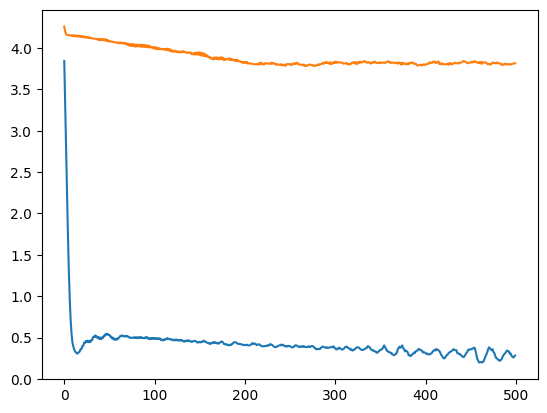

In [48]:
import matplotlib.pyplot as plt

# outlink 자체가 0인 data가 많았음 => user간의 유사성에 의존하는만큼, friend를 댕강댕강해버린 데이터 전처리가 문제..
model = SOREG( l=10, alpha = 0.01,lamb1 = 0.001, lamb2 =0.001, learning_rate=0.01, epochs= 500)

# Train the model
train_loss_list, test_loss_list = model.fit()
train_loss_list = torch.tensor(train_loss_list).detach().numpy()
test_loss_list = torch.tensor(test_loss_list).detach().numpy()
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')

Epoch [0/200], total_loss: 18.041017532348633, train_mae: 3.7869312568397375, test_mae: 4.214206435115462
Epoch [40/200], total_loss: 0.7916808128356934, train_mae: 0.516365555937652, test_mae: 4.107884173412399
Epoch [80/200], total_loss: 0.2988930940628052, train_mae: 0.48128794510540795, test_mae: 4.056190827764182
Epoch [120/200], total_loss: 0.38558146357536316, train_mae: 0.45802538682514593, test_mae: 3.9712404304718874
Epoch [160/200], total_loss: 0.2601753771305084, train_mae: 0.4344865672783165, test_mae: 3.9542525571034135


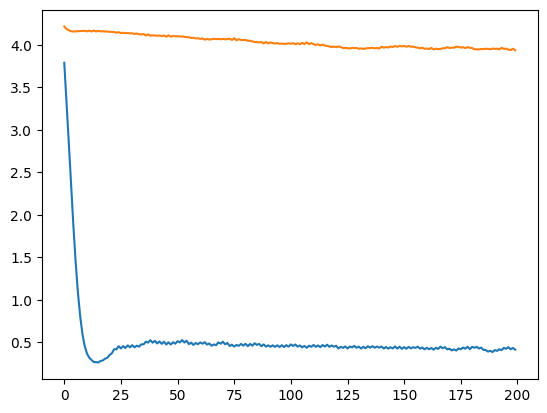

In [25]:
import matplotlib.pyplot as plt

model = SOREG( l=10, alpha = 0.01,lamb1 = 0.001, lamb2 =0.001, learning_rate=0.01, epochs= 500)

# Train the model
train_loss_list, test_loss_list = model.fit()
train_loss_list = torch.tensor(train_loss_list).detach().numpy()
test_loss_list = torch.tensor(test_loss_list).detach().numpy()
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')

In [26]:
train_toy = np.array([
    [5, 2, 0, 3, 0, 4, 0, 0],
    [4, 3, 0, 0, 5, 0, 0, 0],
    [4, 0, 2, 0, 0, 0, 2, 4],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [5, 1, 2, 0, 4, 3, 0, 0],
    [4, 3, 0, 2, 4, 0, 3, 5]
], dtype=float)


trust_toy = np.array([
            [0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1.0, 0.8],
            [0.8,0, 0,0,0,0],
            [0.8, 1.0, 0, 0, 0.6, 0],
            [0,0, 0.4, 0, 0, 0.8],
            [0,0,0,0,0,0]])

In [34]:
model = SOREG(train_R = train_toy, test_R = train_toy, learning_rate = 0.001, trust = trust_toy, l=10, epochs = 3000)

model.fit()
print(model.get_complete_matrix())

Epoch [0/3000], total_loss: 16.555313110351562, train_mae: 3.3035188154740767, test_mae: 3.3035188154740767
Epoch [200/3000], total_loss: 0.20320788025856018, train_mae: 0.6087522506713867, test_mae: 0.6087522506713867
Epoch [400/3000], total_loss: 0.022718515247106552, train_mae: 0.040337107398293236, test_mae: 0.040337107398293236
Epoch [600/3000], total_loss: 0.022357279434800148, train_mae: 0.0008513548157431862, test_mae: 0.0008513548157431862
Epoch [800/3000], total_loss: 0.02219346910715103, train_mae: 0.000663768161426891, test_mae: 0.000663768161426891
Epoch [1000/3000], total_loss: 0.021904507651925087, train_mae: 0.0006589618596163663, test_mae: 0.0006589618596163663
Epoch [1200/3000], total_loss: 0.02140584960579872, train_mae: 0.0006506713953885165, test_mae: 0.0006506713953885165
Epoch [1400/3000], total_loss: 0.020576201379299164, train_mae: 0.0006360574202104049, test_mae: 0.0006360574202104049
Epoch [1600/3000], total_loss: 0.019268792122602463, train_mae: 0.0006147352